# 🛰️🌿Predict crops using EarthDaily simulated constellation

The idea of this hackathon  is to use the **EarthDaily Simulated dataset** to predict the 2019 crops in the current season (as if we were july 15th).
The dataset was pregenerated using the earthdaily python package and the code is available in this notebook.

We have three different years (2018, 2019 and 2020) and our workflow train from a specific year (2018 or 2020) only on spectral bands to predict an independent year (2019). We challenge you to have the maximum accuracy to **predict year 2019** by having only **data up to july 1st** (so a month and a half of data, from may 15th to july 1st).

## Install the conda/mamba environnement

Download mamba : https://github.com/conda-forge/miniforge#mambaforge.

If you're using powershell copy/paste this to have mamba commands : ```powershell -ExecutionPolicy ByPass -NoExit -Command "& 'C:\Users\$Env:UserName\AppData\Local\mambaforge\condabin\mamba.bat' init powershell"```

Then using setup the bids23 environment : `mamba env update --name bids23 --file requirements.yml`.

To run the notebook : `mamba activate bids23` and `jupyter notebook`.

In [2]:
# To run if you have some gdal missing GDAL_DATA warning
import os
os.environ["GDAL_DATA"] = os.environ["CONDA_PREFIX"] + r"\Library\share\gdal"
os.environ["PROJ_LIB"] = os.environ["CONDA_PREFIX"] + r"\Library\share\proj"

In [1]:
from matplotlib import pyplot as plt
from earthdaily import earthdatastore # if you consider to generate the dataset, warning it takes about 1 or 2 hours.
from sklearn import metrics
import numpy as np
import xarray as xr
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
import utils  # specific codes for this hackathon

## Generate dataset from the earthdaily simulation

The **EarthDaily Simulated dataset** is a simulation using various Sensors (Venus, Sentinel-2, Landsat, Modis) in order to have a cloudless version of what we will be able to generate when **EarthDaily constellation** will be here : 5m spatial resolution on most of VNIR bands, daily revisit, radiometric scientific grade quality...
As it is cloudless, it is an Analytics Ready Product.

In [3]:
# To generate the dataset for a specific year
year = 2020
df = utils.crops_layer(year)
bbox = df.to_crs(4326).total_bounds.tolist()
# Add crops names to the dataframe
crops_df = pd.DataFrame(
    list(utils.y_labels.values()),
    list(utils.y_labels.keys()),
    columns=["crop"],
)
df = df.merge(crops_df, how="left", left_on="R20", right_index=True)

Explore this year

In [ ]:
df.explore(column="crop", popup=True, tiles="CartoDB positron", cmap="Set1")

Generate the training data of this year (warning it takes about 2 hours)

In [5]:
generate_dataset = False
days_interval = 5  # one information every x days (default=5)

if generate_dataset:
    eds = earthdatastore.Auth()
    items = eds.search(
        "earthdaily-simulated-cloudless-l2a-cog-edagro",
        bbox=bbox,
        datetime=[f"{year}-05-15", f"{year}-10-15"],
        prefer_alternate="download",
        query=dict(instruments={"contains": "vnir"}),
    )
    # get only one item every 5 days  (days_interval)
    items = [items[i] for i in np.arange(0, len(items), days_interval)]
    datacube_sr = earthdatastore.datacube(
        items,
        bbox=bbox,
        assets={
            "image_file_B": "blue",
            "image_file_G": "green",
            "image_file_Y": "yellow",
            "image_file_R": "red",
            "image_file_RE1": "redege1",
            "image_file_RE2": "redege2",
            "image_file_RE3": "redege3",
            "image_file_NIR": "nir",
        },
    )

    for data_var in datacube_sr:
        data_var_nc = f"data/eds/{year}/{data_var}.nc"
        if os.path.exists(data_var_nc):
            continue
        os.makedirs(f"data/eds/{year}", exist_ok=True)
        ds_stats = earthdatastore.cube_utils.zonal_stats_numpy(
            datacube_sr, df
        )
        ds_stats.to_netcdf(data_var_nc)

## Plot time series per polygon
`X_year` returns the mean values for each polygon and per date.

Here we plot polygon from index 500, 1000, 1500 and 2000.

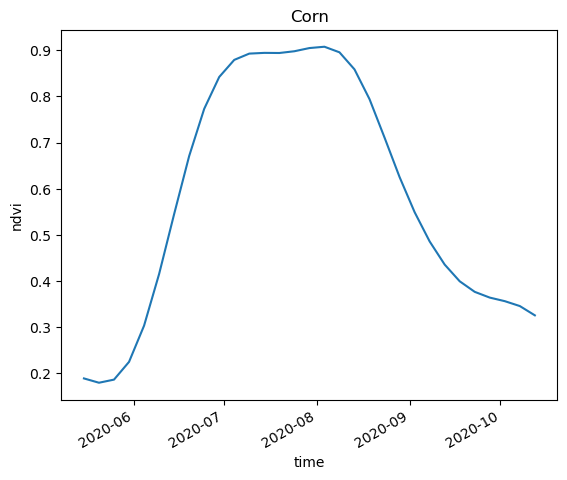

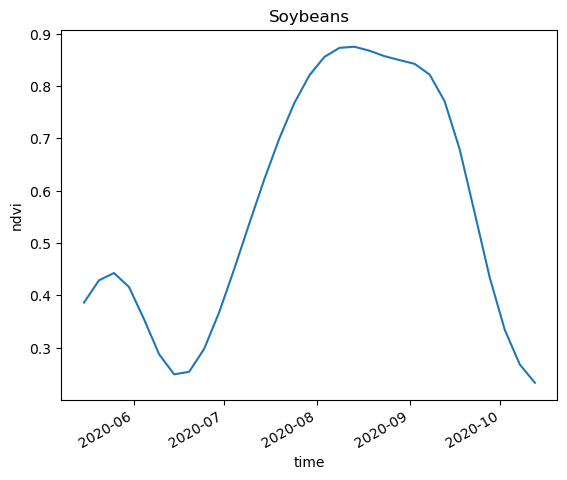

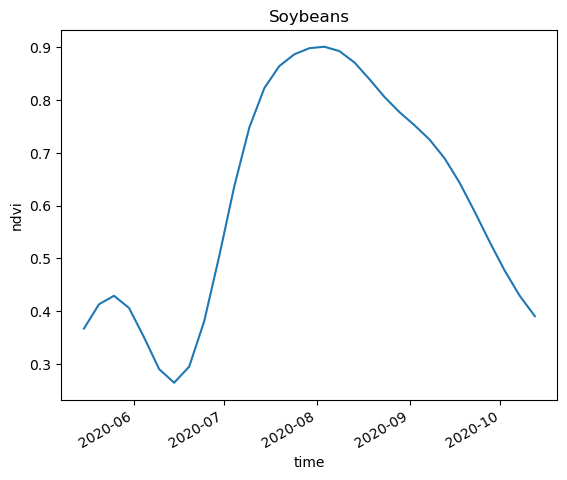

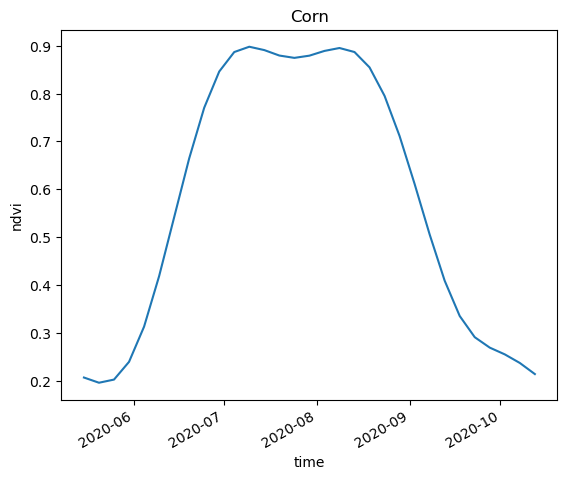

In [4]:
ds = utils.X_year(year, to_numpy=False, return_feature_index=False)
for feature_idx in [500, 1000, 1500, 2000]:
    ds["ndvi"].isel(feature=feature_idx, stats=0).plot()
    plt.title(utils.y_labels[df.iloc[feature_idx][f"R{str(year)[2:]}"]])
    plt.show()

# Generate training/testing data
We have data from **may 15th to october 15th**. But in order to predict the crop during the season, we chose an `end_datetime`, here for the **july 1st**.

In [5]:
# We suppose we have data only up to july 1st.
end_datetime = "07-01"  # july 15th
# you can go up to 10-15 (october 15th)
X_18, y_18 = utils.X_y(2018, end_datetime=end_datetime)
X_19, y_19 = utils.X_y(2019, end_datetime=end_datetime)
X_20, y_20 = utils.X_y(2020, end_datetime=end_datetime)

Here we plot all the NDVI time series for a given year for a specific crop.

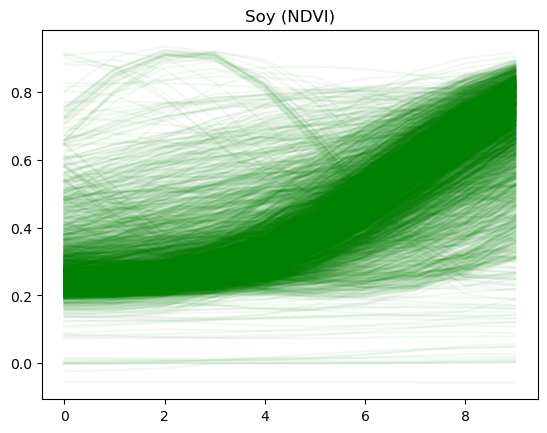

In [6]:
plt.title("Soy (NDVI)")
soy = np.in1d(y_19, 1)
plt.plot(
    X_19[soy, :][:, np.arange(8, X_19.shape[1], 9)].T, alpha=0.05, c="green"
)
plt.show()

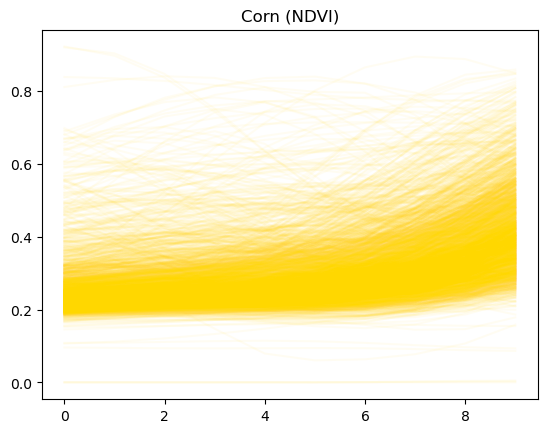

In [7]:
plt.title("Corn (NDVI)")
corn = np.in1d(y_19, 5)
plt.plot(
    X_19[corn, :][:, np.arange(8, X_19.shape[1], 9)].T, alpha=0.05, c="gold"
)
plt.show()

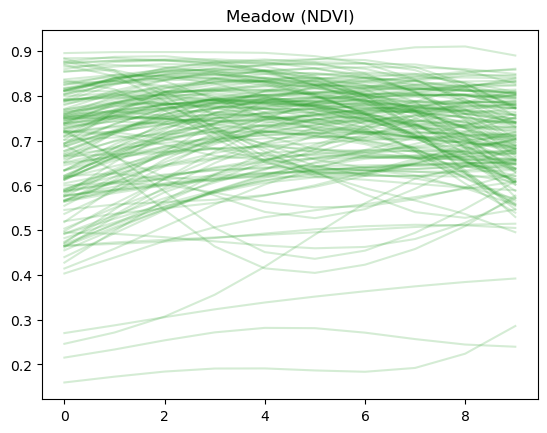

In [8]:
plt.title("Meadow (NDVI)")
meadow = np.in1d(y_19, 176)
plt.plot(
    X_19[meadow, :][:, np.arange(8, X_19.shape[1], 9)].T, alpha=0.2, c="C2"
)
plt.show()

# Machine Learning
We use Random Forest and XGBoost to train with one or two years, and to **predict on year 2019**.

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()  # default parameters

Or use xgboost

In [12]:
import xgboost as xgb

model = xgb.XGBClassifier()

In [10]:
# class are not following number (they are like 1,5,205)... Torch and xgb needs following numbers (0,1,2,3)
y_18 = utils.y_to_range(y_18)
y_19 = utils.y_to_range(y_19)
y_20 = utils.y_to_range(y_20)

In [11]:
# confusion matrix kwargs
cm_plot_kwargs = dict(
    display_labels=list(utils.y_labels.values()),
    cmap="Blues",
    xticks_rotation="vertical",
    colorbar=False,
)

Score when training with 2018 : 0.6258119658119659


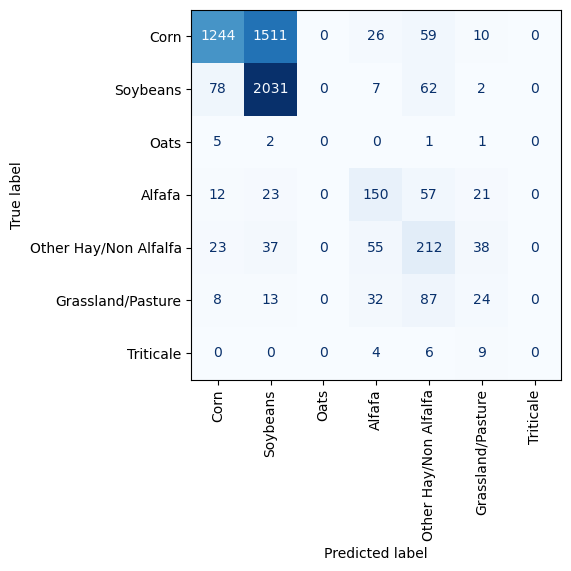

In [12]:
model.fit(X_18, y_18)
y_pred = model.predict(X_19)
score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 : {score}")
y_pred_19 = model.predict(X_19)
metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

Score when training with 2020 : 0.7292307692307692


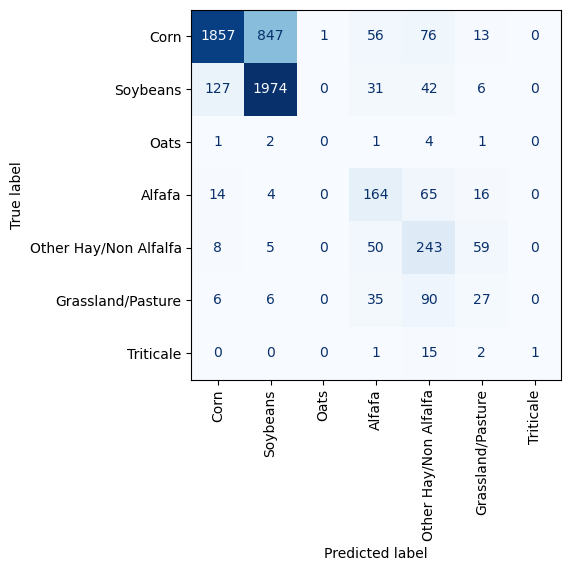

In [13]:
model.fit(X_20, y_20)
y_pred = model.predict(X_19)
score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2020 : {score}")
metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

Score when training with 2018 and 2020 : 0.7239316239316239


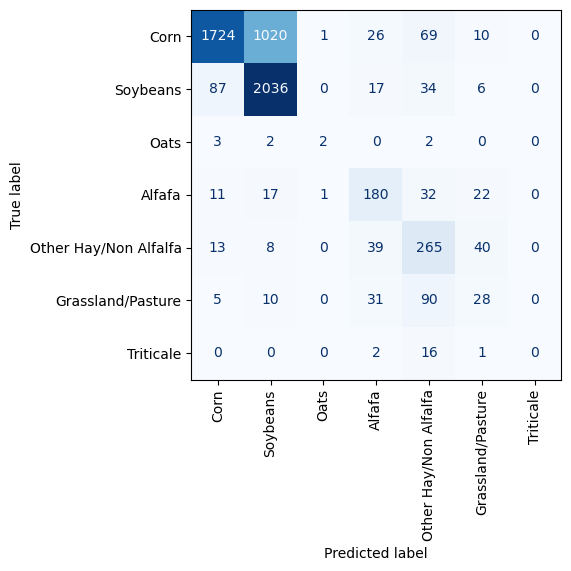

In [14]:
model.fit(np.vstack((X_18, X_20)), np.hstack((y_18, y_20)))
y_pred = model.predict(X_19)
score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 and 2020 : {score}")
metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

# Deep Learning (RNN) : ELECTS model
ELECTS is a RNN algorithm which stands for : End-to-End Learned Early Classification of Time Series for In-Season Crop Type Mapping.

Here's the [github page](https://github.com/MarcCoru/elects/)

In [15]:
import elects

# We must define the number of bands
n_bands = 9  # 8 VNIR + NDVI

In [16]:
train_ds = utils.torch_dataset(X_18, y_18, n_bands=n_bands)
test_ds = utils.torch_dataset(X_19, y_19, n_bands=n_bands)

model = elects.train(
    train_ds,
    test_ds,
    n_classes=len(utils.y_labels),
    epochs=100,
    n_bands=n_bands,
)

epoch 70: trainloss -0.20, testloss 3.27, accuracy 0.75, earliness 0.23. classification loss 9.86, earliness reward 3.3

stopping training. testloss 3.27 did not improve in 30 epochs.


Score when training with 2018 : 0.7446153846153846


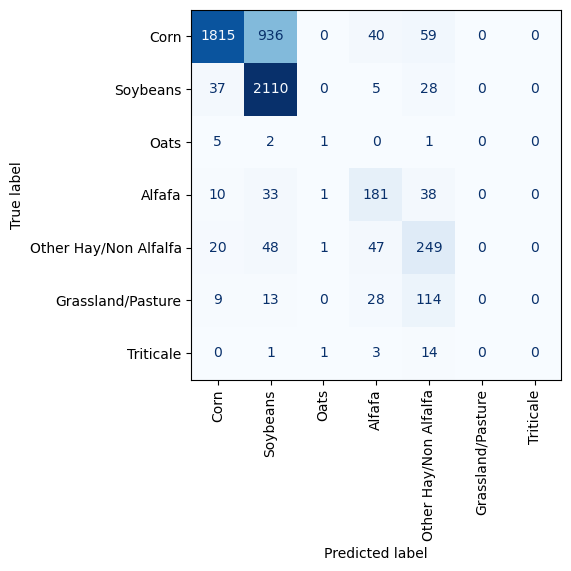

In [18]:
y_pred = model.predict(utils.x_to_torch(X_19, n_bands))[2].detach().numpy()

score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 : {score}")

metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)

# Train with two years

We want to train using 2 years in order to predict year 2019. We have two solutions, to resume from the previous model the training and just train with 2020, or to train a new model using 2018 and 2020 years at once.

resuming from snapshots/model.pth epoch 39


epoch 161: trainloss 0.31, testloss 1.36, accuracy 0.78, earliness 0.48. classification loss 6.93, earliness reward 4.2


stopping training. testloss 1.36 did not improve in 30 epochs.
Score when training with 2018 and 2020 : 0.7876923076923077


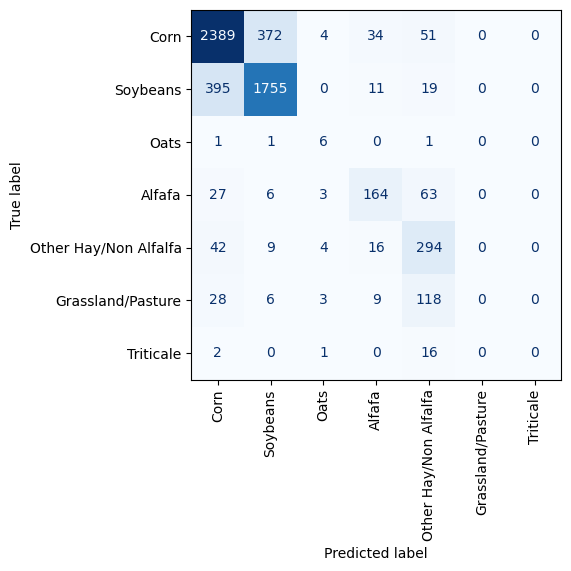

In [19]:
resume = True
# if resume, just add 2020 and use previous trained model
if resume:
    train_ds = utils.torch_dataset(X_20, y_20, n_bands=n_bands)
else:
    train_ds = utils.torch_dataset(
        np.vstack((X_18, X_20)), np.hstack((y_18, y_20)), n_bands=n_bands
    )


model = elects.train(
    train_ds,
    test_ds,
    n_classes=len(utils.y_labels),
    epochs=200,  # add 100 epochs
    n_bands=n_bands,
    resume=resume,  # in order to start using previous training
)

y_pred = model.predict(utils.x_to_torch(X_19, n_bands))[2].detach().numpy()

score = metrics.accuracy_score(y_19, y_pred)
print(f"Score when training with 2018 and 2020 : {score}")

metrics.ConfusionMatrixDisplay.from_predictions(
    y_19, y_pred, **cm_plot_kwargs
)